## 1- Importing libraries

In [1]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
%matplotlib inline

Using TensorFlow backend.


## 2- Data pre-processing and data augmentation

Image Shape: (28, 28)


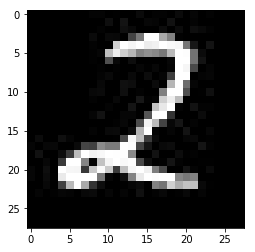

In [2]:
im = Image.open("data/testing/2/477.jpg")
im = np.array(im)
print("Image Shape:", im.shape)
plt.imshow(im, cmap="gray")

In [3]:
val_datagen = ImageDataGenerator(rescale=1./255, # is a value by which we will multiply the data before any other processing
                                  shear_range=0.2, #is for randomly applying shearing transformations
                                  zoom_range=0.2, #is for randomly zooming inside pictures
                                  horizontal_flip=True, #is for randomly flipping half of the images horizontally
                                  rotation_range=40, #is a value in degrees (0-180), a range within which to randomly rotate pictures
                                  width_shift_range=0.2, #which to randomly translate pictures vertically or horizontally
                                  height_shift_range=0.2, 
                                  fill_mode='nearest' #is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.
                                 )


validation_generator = val_datagen.flow_from_directory("data/testing", batch_size=1, 
                                                        class_mode='categorical', 
                                                        color_mode='grayscale', 
                                                        target_size=(28,28)
                                                       )

Found 10000 images belonging to 10 classes.


(1, 28, 28, 1)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


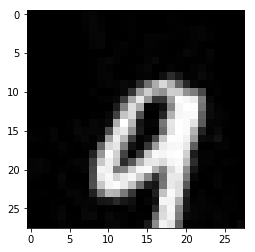

In [4]:
for x, y in validation_generator:
    print(x.shape)
    print(y)
    plt.imshow(x[0,:,:,0], cmap='gray')
    break

In [5]:
validation_generator.classes

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [6]:
dictclass = validation_generator.class_indices

In [7]:
dictclass['5']

5

## 3- Object Oriented Programming

In [8]:
class Image_Classifier():
    def __init__(self, train_folder='data/train', validation_folder='data/validation', 
                  inshape=(28,28,1), num_classes=10, num_train=1000, num_validation=200):
        self.train_folder = train_folder
        self.validation_folder =  validation_folder
        self.inshape = inshape
    
        self.num_classes = num_classes
        self.num_train = num_train
        self.num_validation = num_validation
        
    def model(self, inshape=(28,28,1), num_classes=10, learning_rate=0.001):
        '''
            Three steps to Convolution
                1. Convolution
                2. Activation
                3. Polling
            Repeat Steps 1,2,3 for adding more hidden layers
                4. After that make a fully connected network
            This fully connected network gives ability to the CNN
            to classify the samples
        '''
        model = Sequential()

        model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', 
                         kernel_initializer='glorot_uniform', bias_initializer='zeros', 
                         input_shape=inshape, data_format="channels_last"))
        
        model.add(MaxPooling2D(pool_size=(2,2)))
        
        model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', 
                         kernel_initializer='glorot_uniform', bias_initializer='zeros'))


        model.add(MaxPooling2D(pool_size=(2,2)))
        
        model.add(Flatten())
    
        model.add(Dropout(rate=0.8)) # rate: rate of nodes to be keeped

        model.add(Dense(units=512, activation='relu'))
        
        model.add(Dropout(rate=0.8))

        model.add(Dense(num_classes, activation='softmax'))
        
        # Binary cross-entropy is for multi-label classifications, whereas categorical cross entropy is for multi-class classification where each example belongs to a single class.
        optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        return model
    
    def train(self, batch_size=128, epochs=12, learning_rate=0.001, model_file="my_model.h5", refine = False):
        '''
            Train Process
        '''
        # this is the augmentation configuration we will use for training
        train_datagen = ImageDataGenerator(rescale=1./255, # is a value by which we will multiply the data before any other processing
                                            shear_range=0.2, #is for randomly applying shearing transformations
                                            zoom_range=0.2, #is for randomly zooming inside pictures
                                            horizontal_flip=True, #is for randomly flipping half of the images horizontally
                                            #rotation_range=40, #is a value in degrees (0-180), a range within which to randomly rotate pictures
                                            #width_shift_range=0.2, #which to randomly translate pictures vertically or horizontally
                                            #height_shift_range=0.2, 
                                            #fill_mode='nearest' #is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.
                                          )

        # this is the augmentation configuration we will use for testing:
        # only rescaling
        test_datagen = ImageDataGenerator(rescale=1./255)

        # this is a generator that will read pictures found in
        # subfolers of 'data/train', and indefinitely generate
        # batches of augmented image data
        train_generator = train_datagen.flow_from_directory(self.train_folder,  # this is the target directory
                                                            target_size=(28,28),  # all images will be resized to 150x150
                                                            batch_size=batch_size, 
                                                            color_mode='grayscale',
                                                            #class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels
                                                           )
        # this is a similar generator, for validation data
        validation_generator = test_datagen.flow_from_directory(self.validation_folder, 
                                                                target_size=(28,28),
                                                                batch_size=batch_size, 
                                                                color_mode='grayscale',
                                                                #class_mode='binary'
                                                               )
        if refine:
            model = load_model(model_file)
        else:
            model = self.model(inshape=self.inshape, num_classes=self.num_classes, learning_rate=learning_rate)
        
        ts = time.time()
        tbCallBack = TensorBoard(log_dir='./logs/' + str(ts), histogram_freq=0, write_graph=True, write_images=True)
        
        # To launch tensorbord
        # tensorboard --logdir ./logs
        model.fit_generator(train_generator,
                            steps_per_epoch=self.num_train // batch_size,
                            epochs=epochs,
                            validation_data=validation_generator,
                            validation_steps=self.num_validation // batch_size,
                            callbacks=[tbCallBack])
        
        # You can use model.save(filepath) to save a Keras model into a single HDF5 file which will contain:
        # 1- the architecture of the model, allowing to re-create the model
        # 2- the weights of the model
        # 3- the training configuration (loss, optimizer)
        # 4- the state of the optimizer, allowing to resume training exactly where you left off.

        model.save(model_file)
        
        
    def predict(self, x, model_file="my_model.h5"):
        model = load_model(model_file)
        prediction = model.predict(x)
        return prediction

## 4- Training Step

In [9]:
im_classifier = Image_Classifier(train_folder = 'data/training', 
                                 validation_folder = 'data/testing', 
                                 inshape=(28,28,1), num_classes=10,
                                 num_train=60000, num_validation=1000)

im_classifier.train(batch_size=128, epochs=12, learning_rate=0.001)
# im_classifier.train(batch_size=128, epochs=20, learning_rate=0.0001, refine=True, model_file="my_model.h5")

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/12
468/468 [==============================] - 63s 135ms/step - loss: 1.1064 - acc: 0.6216 - val_loss: 0.3265 - val_acc: 0.9018
Epoch 2/12
468/468 [==============================] - 62s 133ms/step - loss: 0.6968 - acc: 0.7677 - val_loss: 0.2584 - val_acc: 0.9330
Epoch 3/12
468/468 [==============================] - 60s 128ms/step - loss: 0.6052 - acc: 0.8015 - val_loss: 0.1969 - val_acc: 0.9397
Epoch 4/12
468/468 [==============================] - 61s 129ms/step - loss: 0.5359 - acc: 0.8274 - val_loss: 0.1996 - val_acc: 0.9442
Epoch 5/12
468/468 [==============================] - 62s 132ms/step - loss: 0.4928 - acc: 0.8434 - val_loss: 0.1400 - val_acc: 0.9621
Ep

## 5- Inference Step

In [10]:
im = Image.open("data/testing/6/870.jpg")
im = np.array(im)
im = np.expand_dims(im, axis=0)
im = np.expand_dims(im, axis=3)
print(im.shape)
im_classifier = Image_Classifier()
prediction = im_classifier.predict(im, model_file="my_model.h5")
prediction_digit = prediction[0].argmax()
print("The corresponding image digit is :", prediction_digit)

(1, 28, 28, 1)
The corresponding image digit is : 6



# Fine-tuning the top layers of a pre-trained network (Transfert Learning)
Fine-tuning consist in starting from a trained network, then re-training it on a new dataset using very small weight updates.
* instantiate the convolutional base of the model and load its weights
* add our defined fully-connected model on top, and load its weights
* freeze the layers of the pretrained model up to the last convolutional block

In [11]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

In [12]:
# create the base pre-trained model
# base_model = InceptionV3(weights='imagenet') #, include_top=False)

## Create a new model
Now that we have set the trainable parameters of our base network, we would like to add a classifier on top of the convolutional base. We will simply add a fully connected layer followed by a softmax layer with 3 outputs. This is done as given below.

## Load the pre-trained model
First, we will load a inception-v3 model without the top layer ( which consists of fully connected layers ).

In [14]:
# create the base pre-trained model over a custom input tensor
# Giving that the default input shape is (299,299,3)
# Change the input shape
# this could also be the output a different Keras model or layer
print(K.image_data_format())
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(139, 139, 3))

channels_last


In [15]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_3
2 batch_normalization_1
3 activation_1
4 conv2d_4
5 batch_normalization_2
6 activation_2
7 conv2d_5
8 batch_normalization_3
9 activation_3
10 max_pooling2d_3
11 conv2d_6
12 batch_normalization_4
13 activation_4
14 conv2d_7
15 batch_normalization_5
16 activation_5
17 max_pooling2d_4
18 conv2d_11
19 batch_normalization_9
20 activation_9
21 conv2d_9
22 conv2d_12
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_8
29 conv2d_10
30 conv2d_13
31 conv2d_14
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_18
42 batch_normalization_16
43 activation_16
44 conv2d_16
45 conv2d_19
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_15
52 conv2d_17
53 conv2d_20
54 conv2d_21
55 batch_normalization_13
56 batch_nor

## Adding classification layers

In [16]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

## Freeze the required layers
In Keras, each layer has a parameter called “trainable”. For freezing the weights of a particular layer, we should set this parameter to False, indicating that this layer should not be trained. That’s it! We go over each layer and select which layers we want to train.

In [17]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [18]:
# Show a summary of the model. Check the number of trainable parameters
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 139, 139, 3)  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 69, 69, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 69, 69, 32)   96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 69, 69, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_4 (